In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from rdkit import rdkit.Chem


In [2]:
org_df = pd.read_csv('EGFR_Chembl_raw.csv', sep = ';')
org_df.shape

C:\Users\Tim\AppData\Local\Temp\ipykernel_19400\204613330.py:1: DtypeWarning: Columns (3,4,5,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  org_df = pd.read_csv('EGFR_Chembl_raw.csv', sep = ';')


(16715, 46)

In [3]:
org_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 46 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Molecule ChEMBL ID          16715 non-null  object 
 1   Molecule Name               2246 non-null   object 
 2   Molecule Max Phase          16715 non-null  object 
 3   Molecular Weight            16715 non-null  object 
 4   #RO5 Violations             16715 non-null  object 
 5   AlogP                       16715 non-null  object 
 6   Compound Key                16715 non-null  object 
 7   Smiles                      16683 non-null  object 
 8   Standard Type               16715 non-null  object 
 9   Standard Relation           15336 non-null  object 
 10  Standard Value              15336 non-null  float64
 11  Standard Units              15478 non-null  object 
 12  pChEMBL Value               11990 non-null  float64
 13  Data Validity Comment       367

<Axes: >

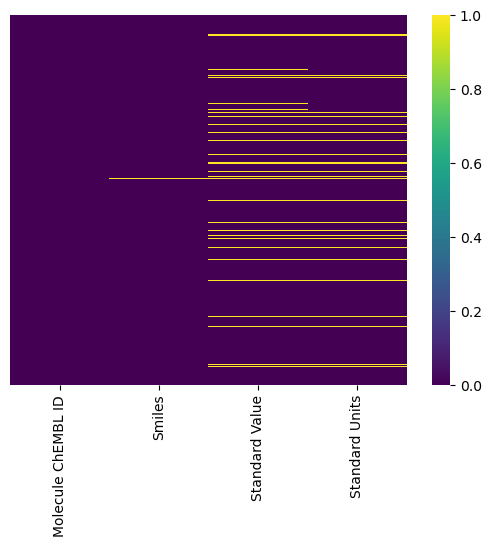

In [4]:
sns.heatmap(org_df.isnull()[['Molecule ChEMBL ID','Smiles','Standard Value', 'Standard Units']],cbar=True,yticklabels=False,cmap = 'viridis')

In [9]:
org_df['Data Validity Comment'].unique()

array([nan, 'Outside typical range', 'Potential transcription error'],
      dtype=object)

<Axes: >

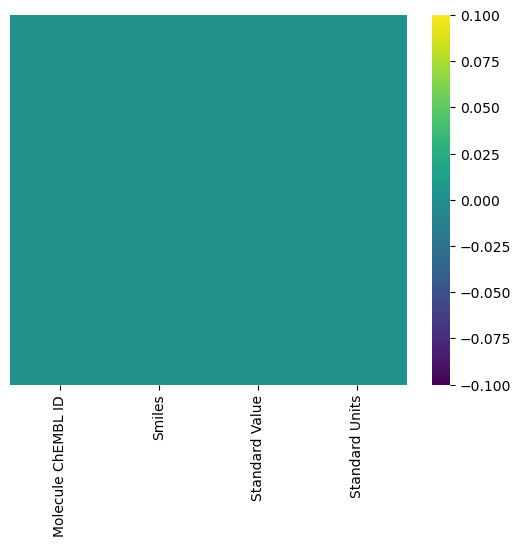

In [10]:
org_df.dropna(axis = 0, subset = ['Molecule ChEMBL ID','Smiles','Standard Value', 'Standard Units'], inplace = True)
sns.heatmap(org_df.isnull()[['Molecule ChEMBL ID','Smiles','Standard Value', 'Standard Units']],cbar=True,yticklabels=False,cmap = 'viridis')

In [18]:
org_df.fillna(value = {'Data Validity Comment':'No Comment'}, inplace = True)

In [19]:
org_df['Data Validity Comment'].value_counts()

No Comment                       14962
Outside typical range              314
Potential transcription error       53
Name: Data Validity Comment, dtype: int64

In [22]:
df = org_df[org_df['Data Validity Comment'] == 'No Comment'] #Save?
df['Data Validity Comment'].value_counts()

No Comment    14962
Name: Data Validity Comment, dtype: int64